In [1]:
from vit_mae import mae_vit_tiny_patch16
from dataset import preTrainDataset, processedPreTrainDataset
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import random

/home/guoxin/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = mae_vit_tiny_patch16(signal_length=480).to("cuda")
ckpt = torch.load(
    "/home/guoxin/mae/checkpoint-160.pth"
)
# model = vit_tiny_patch4(signal_length=480).to('cuda')
# ckpt = torch.load(f'/home/qingyuan/workspace/maecg/trained_weights/ViT1D_original_480.pth')
# model = swin1d_t().to('cuda')
# ckpt = torch.load('/home/qingyuan/workspace/maecg/trained_weights/SwinTransformer1D_original_480.pth')
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [3]:
# shaoxing = preTrainDataset(['../storage/ssd/public/shaoxing/resampled360/'], 480, cuda=False)
# incart = torch.load("../storage/ssd/public/guoxin/incartdb/unlabeled.pth")
mit = torch.load("../storage/ssd/public/guoxin/mitdb/unlabeled.pth")

In [11]:
idx = random.randint(0, len(mit)-1)

In [ ]:
# signal =shaoxing[idx]
# signal =mit[idx][0][0]
# plt.plot(signal)
# plt.show()
# plt.savefig("mae_example_ori.pdf", format="pdf", bbox_inches="tight")


In [12]:
# latent, mask, ids_restore = model.forward_encoder(shaoxing[idx].unsqueeze(0).transpose(-1, -2).cuda(), 0.6)
latent, mask, ids_restore = model.forward_encoder(mit[idx][0].unsqueeze(0).cuda(), 0.6)
pred = model.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]

In [13]:
# masked_input=shaoxing[idx].squeeze()*(1-mask.cpu().squeeze().repeat_interleave(16))
masked_input=mit[idx][0].squeeze()*(1-mask.cpu().squeeze().repeat_interleave(16))

In [14]:
masked_input=masked_input.numpy()
masked_input = np.ma.masked_where(masked_input==0, masked_input)

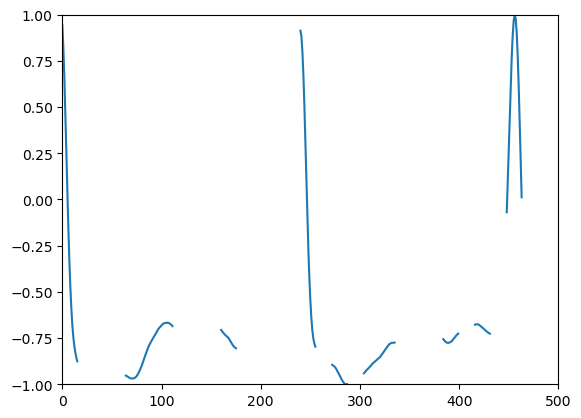

In [15]:
plt.plot(masked_input)
plt.xlim([0, 500])
plt.ylim([-1, 1])
plt.show()
# plt.savefig("mae_example_masked.pdf", format="pdf", bbox_inches="tight")


In [16]:
pred_unpatchified = model.unpatchify(pred).squeeze()

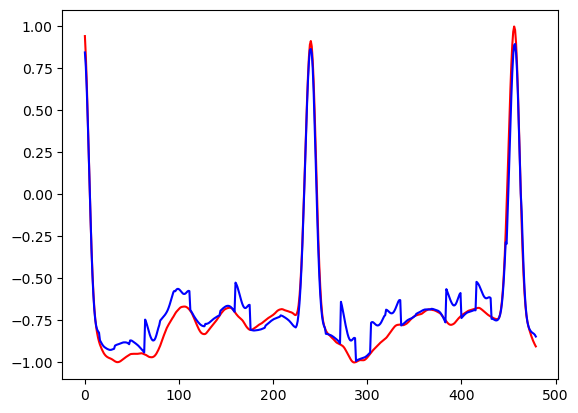

In [17]:
plt.plot(mit[idx][0][0], 'r')
plt.plot(pred_unpatchified.detach().cpu().numpy(), 'b')
plt.show()
# plt.savefig("mae_example_resconst.pdf", format="pdf", bbox_inches="tight")


In [ ]:
from dataset_old import MITBIH

mitbih = MITBIH(directory='../storage/ssd/public/datagen/dataset/mit-bih-arrhythmia-database-1.0.0',
                lcadc=False,
                window_size=480)
# dataset = INCART('/home/qingyuan/workspace/storage/ssd/public/mit-bih-long-term-ecg-database-1.0.0')
# dataset = INCART('/home/qingyuan/workspace/storage/ssd/public/incart/files/incartdb/1.0.0')
# dataset = INCART('/home/qingyuan//workspace/storage/ssd/public/edb/1.0.0')

# print(len(mitbih.ds1))
# print(sum([len(v)for k,v in mitbih.ds2_records.items()]))


46251
45198

In [ ]:
def val_on(dl, prefix='v', recorder=None, progress_bar=None):
    model.eval()
    conf_matrix= torch.zeros((2,2), device='cuda')
    correct= []
    logits = []
    for signal, label, _ in dl:
        signal = signal.float().to('cuda')
        label = label.float().to('cuda').unsqueeze(1)
        with torch.no_grad():
            out = model(signal)
            logit = torch.sigmoid(out)
            pred = torch.where(logit > 0.5, 1, 0)
            for i in range(2):
                for j in range(2):
                    conf_matrix[i][j]+=((pred==i)&(label==j)).sum()
            correct.append(pred==label)
            logits.append(logit)

        progress_bar.update(label.shape[0])
    return conf_matrix, torch.cat(correct,dim=0), torch.cat(logits,dim=0)

In [ ]:
conf_matrix_all = torch.zeros((2, 2),device='cuda')
result = {}
for record_num, ds in mitbih.ds2_records.items():

    # Load the global trained model

    # model.freeze_conv()
    # Define train/val set for current record
    ps_test_dl = torch.utils.data.DataLoader(ds, batch_size=1024, num_workers=10, shuffle=False)

    # Init the recorder for patient specific training
    with tqdm(total=len(ds), desc=f'Test {record_num}') as progress_bar:
        conf_matrix, correct, logits = val_on(ps_test_dl, progress_bar=progress_bar)
        conf_matrix_all += conf_matrix
        result[record_num] = (correct, logits)


In [ ]:
conf_matrix_all

tensor([[27946.,  2273.],
        [ 5228., 10716.]], device='cuda:0') 83.75

In [ ]:
conf_matrix_all[0][1]

In [ ]:
print('acc',(conf_matrix_all[0][0]+conf_matrix_all[1][1])/conf_matrix_all.sum())

In [ ]:
# cm = torch.tensor([[27946., 2273.], [5228., 10716.]], device='cuda:0')
cm = conf_matrix_all
p = 0 if (cm[1][1] + cm[1][0]) == 0 else cm[1][1] / (cm[1][1] + cm[1][0])


r = 0 if (cm[1][1] + cm[0][1]) == 0 else cm[1][1] / (cm[1][1] + cm[0][1])


f1=0 if (p + r) == 0 else 2 * p * r / (p + r)

In [ ]:
print(f1)

In [ ]:
conf_matrix_all[0][1]

In [ ]:
sata ={}
for r in result:
    correct, logits = result[r]
    mistake = torch.argwhere(correct.squeeze() == False).squeeze(-1).cpu().numpy()
    print(f'{r}\t{len(mistake)}')
    symbols = []
    for i in mistake:
        signal, label, (annpos, symbol) = mitbih.ds2_records[r][i]
        if symbol not in sata:
            sata[symbol]=0
        sata[symbol]+=1
        symbols.append((label, symbol))
    # if r == 232:
    #     break

In [ ]:
print(r, list(zip(mistake, symbols, logits.squeeze(-1).cpu().numpy())))
print(len(mistake))


In [ ]:
sata = {}
for _,_,(_,annsymbol) in mitbih.ds2_records[232]:
    if annsymbol not in sata:
        sata[annsymbol]=0
    sata[annsymbol]+=1


In [ ]:
sata

In [ ]:
signal, label, (annpos, symbol) = mitbih.ds2_records[232][1212]
plt.plot(signal)
plt.show()
print(label)
print(annpos/360)
print(symbol)

In [ ]:
len(mitbih.ds2_records[105])

In [ ]:
signal, label, (annpos, symbol) = mitbih.ds2_records[100][61]
plt.plot(signal)
plt.show()
print(label)
print(annpos / 360)
print(symbol)

In [ ]:
mask.shape